In [17]:
import pandas as pd
import yfinance as yf
from prophet import Prophet
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [18]:
import yfinance as yf

# Define the ticker symbol for Tesla
symbol = 'TSLA'
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download Tesla's historical data
btc_data = yf.download(symbol, start=start_date, end=end_date)

# Display the data
print(btc_data)


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2020-01-02   28.684000   28.713333   28.114000   28.299999  142981500
2020-01-03   29.534000   30.266666   29.128000   29.366667  266677500
2020-01-06   30.102667   30.104000   29.333332   29.364668  151995000
2020-01-07   31.270666   31.441999   30.224001   30.760000  268231500
2020-01-08   32.809334   33.232666   31.215334   31.580000  467164500
...                ...         ...         ...         ...        ...
2024-12-24  462.279999  462.779999  435.140015  435.899994   59551800
2024-12-26  454.130005  465.329987  451.019989  465.160004   76366400
2024-12-27  431.660004  450.000000  426.500000  449.519989   82666800
2024-12-30  417.410004  427.000000  415.750000  419.399994   64941000
2024-12-31  403.839996  427.929993  402.540009  423.790009   76825100

[1258 rows x 5 colu

In [19]:
# Download additional feature: Trading Volume
btc_df = btc_data[['Close', 'Volume']].reset_index()
btc_df.columns = ['ds', 'y', 'volume']  # Prophet requires columns 'ds' (date) and 'y' (value)

In [20]:
# Check stationarity using Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

print("Stationarity Test:")
adf_test(btc_df['y'])

Stationarity Test:
ADF Statistic: -2.1534351262883535
p-value: 0.22357752529704183
Critical Values: {'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}
The series is not stationary.


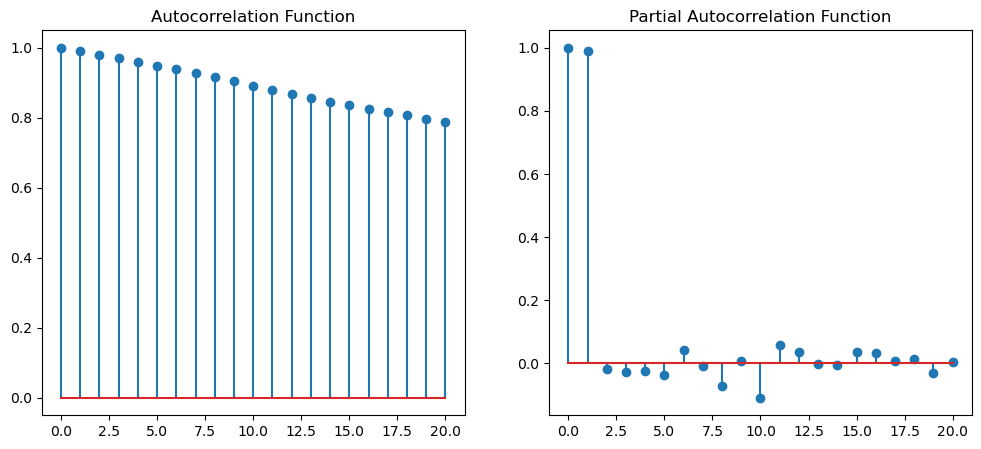

In [21]:
# Check serial correlation using ACF and PACF
lag_acf = acf(btc_df['y'], nlags=20)
lag_pacf = pacf(btc_df['y'], nlags=20)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.stem(lag_acf)
plt.title("Autocorrelation Function")
plt.subplot(122)
plt.stem(lag_pacf)
plt.title("Partial Autocorrelation Function")
plt.show()

In [22]:
# Initialize and fit Prophet model
model = Prophet()
model.fit(btc_df)


15:23:44 - cmdstanpy - INFO - Chain [1] start processing
15:23:45 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# Create future dataframe for predictions
future = model.make_future_dataframe(periods=365)  # Forecast for 1 year ahead
future.fillna(method='ffill', inplace=True)
forecast = model.predict(future)


C:\Users\TEMP.DESKTOP-SC7NPT3\AppData\Local\Temp\ipykernel_6236\3190491440.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future.fillna(method='ffill', inplace=True)


In [24]:
# Extract trend from Prophet's forecast
btc_df['trend'] = model.predict(btc_df)['trend']


In [25]:
# Prepare data for machine learning model
btc_df['lag_1'] = btc_df['y'].shift(1)
btc_df.dropna(inplace=True)
X = btc_df[['trend', 'lag_1']]
y = btc_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [27]:
# Make predictions
rf_predictions = rf_model.predict(X_test)

In [28]:
# Performance metrics
y_true = btc_df['y']
y_pred = forecast['yhat'][:len(y_true)]
mse = mean_squared_error(y_test, rf_predictions)
rmse = np.sqrt(mse)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 99.89101888739421
Root Mean Squared Error (RMSE): 9.994549458949823


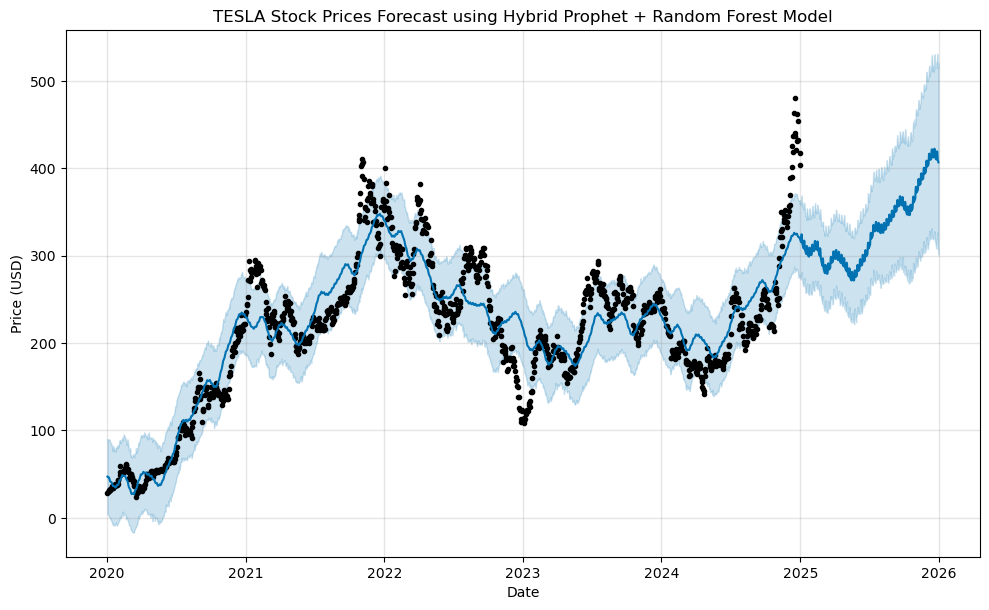

In [29]:
# Plot forecast
fig = model.plot(forecast)
plt.title("TESLA Stock Prices Forecast using Hybrid Prophet + Random Forest Model")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

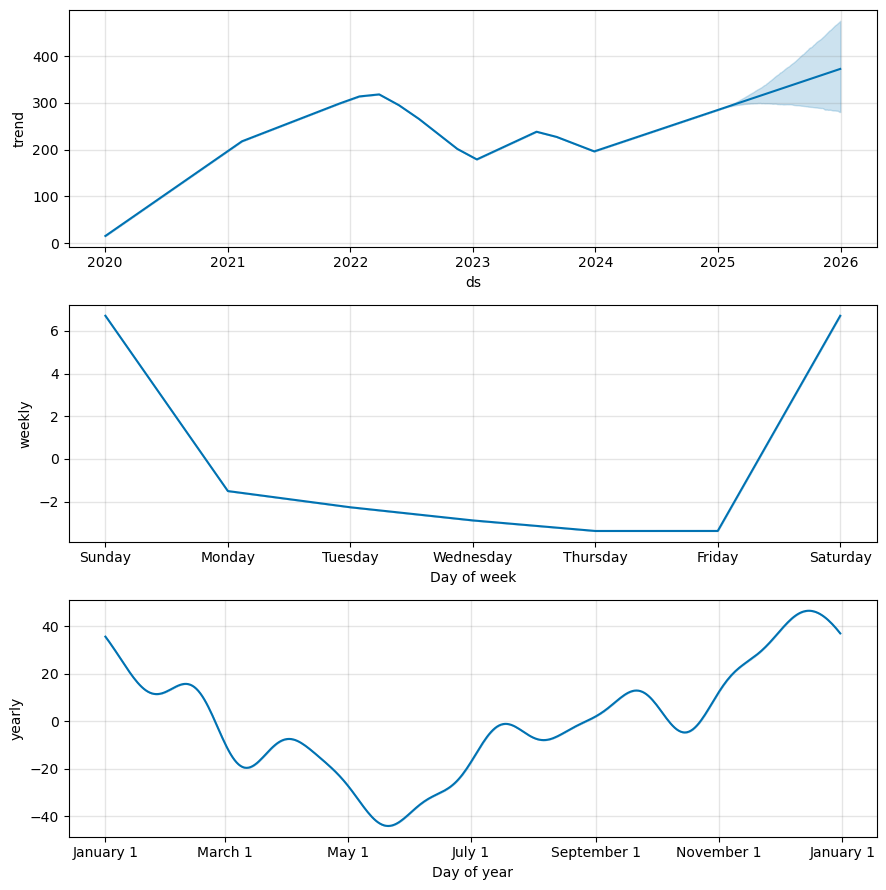

In [30]:
# Plot forecast components
fig2 = model.plot_components(forecast)
plt.show()

In [31]:
# Display forecasted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1618,2025-12-27,419.163951,318.919326,522.858107
1619,2025-12-28,418.491370,326.221786,530.606594
1620,2025-12-29,409.554097,307.743076,518.041557
1621,2025-12-30,408.021728,307.276219,514.085325
1622,2025-12-31,406.587130,301.059604,520.835255
